In [1]:
import numpy as np
import pandas as pd
import datetime

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import os
import string

from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, preprocessing)
import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_movies = pd.read_csv('movies.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

In [3]:
#Using genome tags with a relevance score larger than 0.7 to only get the most relevant tags
df_genome_scores_cust = df_genome_scores[df_genome_scores['relevance'] > 0.7]
df_genome_scores_cust = pd.merge(df_genome_scores_cust,df_genome_tags,on='tagId')
df_genome_scores_cust = df_genome_scores_cust.drop(columns = ['tagId', 'relevance'])
df_genome_scores_cust['tag'] = df_genome_scores_cust['tag'].str.replace(' ','_')
df_genome_scores_cust['tag'] = df_genome_scores_cust['tag'] + ' '
df_genome_scores_cust = df_genome_scores_cust.groupby(by = 'movieId').sum()
df_genome_scores_cust['g_tag'] = df_genome_scores_cust['tag']
df_genome_scores_cust.drop(columns = 'tag', inplace = True)

In [4]:
#Prepare tags dataframe
df_tags_cust = df_tags.drop(columns = ['userId', 'timestamp'])
df_tags_cust['tag'] = df_tags_cust['tag'].str.replace(' ', '_')
df_tags_cust['tag'] = df_tags_cust['tag'] + ' '
df_tags_cust = df_tags_cust.groupby(by = 'movieId').sum()
df_tags_cust.reset_index(level=0, inplace=True)

In [5]:
#Merge dfs to create more data to build features from
df_movie_imdb = pd.merge(df_movies,df_imdb,on='movieId',how='inner')
df_movie_imdb_tags = pd.merge(df_movie_imdb,df_tags_cust,on='movieId',how='outer')
df_movie_imdb_tags = pd.merge(df_movie_imdb_tags,df_genome_scores_cust,on='movieId',how = 'outer')

#Let's drop the movies which have no title
df_movie_imdb_tags = df_movie_imdb_tags[df_movie_imdb_tags['title'].notna()]

#Split year from title and remove parentheses
df_movie_imdb_tags['year'] = df_movie_imdb_tags['title'].str[-6:]
df_movie_imdb_tags['year'] = df_movie_imdb_tags['year'].str.replace(r"(","")
df_movie_imdb_tags['year'] = df_movie_imdb_tags['year'].str.replace(r")","")
#df_movie_imdb_tags['title'] = df_movie_imdb_tags['title'].str[:-7]

#Make decade column
df_movie_imdb_tags['decade'] = df_movie_imdb_tags['year'].str[:-1] + '0s'

#Fix 'no genres listed
df_movie_imdb_tags['genres'] = df_movie_imdb_tags['genres'].replace("(no genres listed)",np.nan)

#Drop columns which have NaN in 'genres',	'title_cast',	'director',	'runtime',	'budget',	'plot_keywords',	'tag'
#df_movie_imdb_tags = df_movie_imdb_tags.dropna(axis=0, subset=['genres',	'title_cast',	'director',	'runtime',	'budget',	'plot_keywords',	'tag'], how = 'all') 

#We need to get the columns in the correct format however so we replace | with a space, and spaces with commas
df_movie_imdb_tags['title_cast'] = df_movie_imdb_tags['title_cast'].str.replace(' ', '_')
df_movie_imdb_tags['title_cast'] = df_movie_imdb_tags['title_cast'].str.replace('|', ' ')

df_movie_imdb_tags['director'] = df_movie_imdb_tags['director'].str.replace(' ', '_')

df_movie_imdb_tags['plot_keywords'] = df_movie_imdb_tags['plot_keywords'].str.replace(' ', '_')
df_movie_imdb_tags['plot_keywords'] = df_movie_imdb_tags['plot_keywords'].str.replace('|', ' ')

df_movie_imdb_tags['genres'] = df_movie_imdb_tags['genres'].str.replace(' ', '_')
df_movie_imdb_tags['genres'] = df_movie_imdb_tags['genres'].str.replace('|', ' ')

#We also replace null values with a blank
df_movie_imdb_tags = df_movie_imdb_tags.fillna('')

In [6]:
df_movie_imdb_tags.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,tag,g_tag,year,decade
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,81,"$30,000,000",toy rivalry cowboy cgi_animation,Owned imdb_top_250 Pixar Pixar time_travel chi...,adventure animated animation cartoon cgi child...,1995,1990s
1,2,Jumanji (1995),Adventure Children Fantasy,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan_Hensleigh,104,"$65,000,000",board_game adventurer fight game,Robin_Williams time_travel fantasy based_on_ch...,adventure childhood children family fun fun_mo...,1995,1990s
2,3,Grumpier Old Men (1995),Comedy Romance,Walter_Matthau Jack_Lemmon Sophia_Loren Ann-Ma...,Mark_Steven_Johnson,101,"$25,000,000",boat lake neighbor rivalry,funny best_friend duringcreditsstinger fishing...,original comedy good_sequel sequel sequels,1995,1990s
3,4,Waiting to Exhale (1995),Comedy Drama Romance,Whitney_Houston Angela_Bassett Loretta_Devine ...,Terry_McMillan,124,"$16,000,000",black_american husband_wife_relationship betra...,based_on_novel_or_book chick_flick divorce int...,chick_flick divorce girlie_movie relationships...,1995,1990s
4,5,Father of the Bride Part II (1995),Comedy,Steve_Martin Diane_Keaton Martin_Short Kimberl...,Albert_Hackett,106,"$30,000,000",fatherhood doberman dog mansion,aging baby confidence contraception daughter g...,family feel-good original comedy good_sequel s...,1995,1990s


In [7]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=50, stop_words='english')
X = vectorizer.fit_transform(df_movie_imdb_tags.plot_keywords).toarray()

In [8]:
X = pd.DataFrame(X, columns=vectorizer.get_feature_names())
X.shape

(24866, 50)

In [9]:
scaler = StandardScaler()
pca = decomposition.PCA(n_components=2)

print("Computing PCA projection")
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

Computing PCA projection


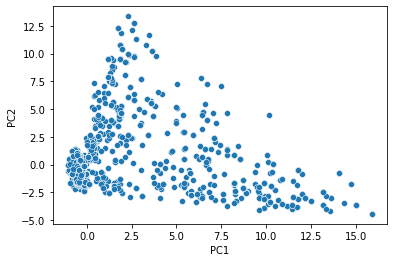

The first two principal components explain 6.0 % of the variance in the data


In [10]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()
print("The first two principal components explain " + 
      str(np.round(sum(pca.explained_variance_ratio_[:2]),2)*100) + " % of the variance in the data")

In [11]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['plot_keywords'] = df_movie_imdb_tags['plot_keywords']
pca_df.head()

,PC1,PC2,plot_keywords
0,-0.182222,-0.098505,toy rivalry cowboy cgi_animation
1,-0.182222,-0.098505,board_game adventurer fight game
2,-0.182222,-0.098505,boat lake neighbor rivalry
3,-0.182222,-0.098505,black_american husband_wife_relationship betra...
4,-0.554706,0.857909,fatherhood doberman dog mansion


In [12]:
data = [
    go.Scatter(
        x = pca_df.iloc[:2000,0].values,
        y = pca_df.iloc[:2000,1].values,
        text = pca_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'red'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

In [13]:
print("Computing MDS embedding")
mds = manifold.MDS(n_components=2, 
                   n_init=2, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')

X_mds = mds.fit_transform(X.iloc[:2000,:])

print("Stress: %f" % mds.stress_)

Computing MDS embedding
Stress: 61206.873747


In [14]:
mds_df = pd.DataFrame(X_mds, columns=['D1', 'D2'])
mds_df['plot_keywords'] = df_movie_imdb_tags['plot_keywords']

In [15]:
data = [
    go.Scatter(
        x = mds_df.iloc[:2000,0].values,
        y = mds_df.iloc[:2000,1].values,
        text = mds_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'red'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

In [16]:
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)

X_tsne = tsne.fit_transform(X.iloc[:5000,:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.788818
[t-SNE] KL divergence after 1000 iterations: -0.056380


In [17]:
tsne_df = pd.DataFrame(X_tsne, columns=['D1', 'D2'])
tsne_df['plot_keywords'] = df_movie_imdb_tags['plot_keywords']

In [18]:
data = [
    go.Scatter(
        x = tsne_df.iloc[:2000,0].values,
        y = tsne_df.iloc[:2000,1].values,
        text = tsne_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'black'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

Using Elbow method to find optimal value of K

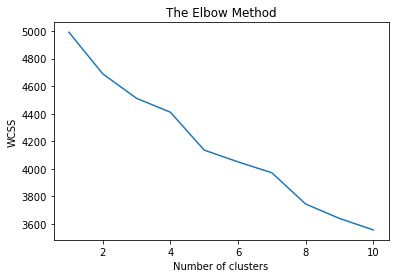

In [19]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
from sklearn.cluster import MiniBatchKMeans
clusters = MiniBatchKMeans(n_clusters=3, batch_size=1024, random_state=20).fit_predict(X)

In [23]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = decomposition.PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = manifold.TSNE().fit_transform(decomposition.PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

In [ ]:
plot_tsne_pca(X, clusters)